## Analysis of the liver region identified by INSPIRE

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

### Load results

In [2]:
res_path = "Results/INSPIRE_developmental_stages"
adata = sc.read_h5ad(res_path + "/adata_inspire.h5ad")

### Find differentially expressed genes in INSPIRE's detected brain region III

In [3]:
## load data in one slice
meta_full = adata.obs.copy()
preprocessed_data_path = "examples/mouse_embryo_stereoseq/run_inspire/preprocessed_data"
slice_name_list = ["E16.5_E1S1", "E15.5_E1S2", "E14.5_E1S1", "E13.5_E1S3",
                   "E12.5_E1S1", "E11.5_E1S1", "E10.5_E2S1", "E9.5_E1S1"]

i = 0
adata = sc.read_h5ad(os.path.join(preprocessed_data_path, "raw_counts/"+slice_name_list[i]+".h5ad"))
adata.obs.index = adata.obs.index + "-" + str(i)
meta = meta_full.loc[adata.obs.index]
adata.obs["annotation"] = meta["annotation"]

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=10)

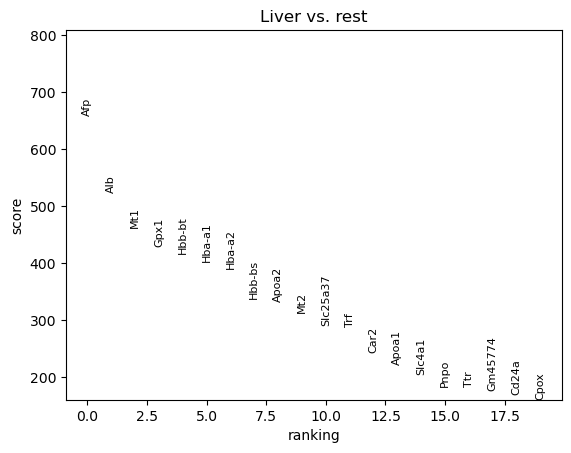

In [5]:
sc.tl.rank_genes_groups(adata, groupby="annotation", groups=['Liver'], method='t-test')
sc.pl.rank_genes_groups(adata, groups=['Liver'], n_genes=20)

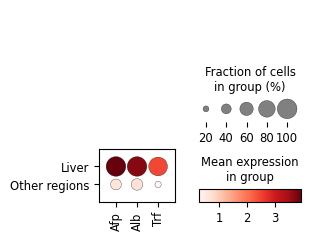

In [6]:
adata.obs["is_liver"] = "Other regions"
adata.obs["is_liver"][adata.obs["annotation"]=="Liver"] = "Liver"
sc.pl.dotplot(adata, ["Afp","Alb","Trf"], "is_liver", dendrogram=False)

### Visualize the identified brain region III and the differentially expressed genes

In [7]:
slice_name_list = ["E16.5_E1S1", "E15.5_E1S2", "E14.5_E1S1", "E13.5_E1S3",
                   "E12.5_E1S1", "E11.5_E1S1", "E10.5_E2S1", "E9.5_E1S1"]
preprocessed_data_path = "examples/mouse_embryo_stereoseq/run_inspire/preprocessed_data"

n_slices = len(slice_name_list)
loc_list = []
for i in range(n_slices):
    # Load data
    print("Load data", slice_name_list[i])
    adata = sc.read_h5ad(os.path.join(preprocessed_data_path, "raw_counts/"+slice_name_list[i]+".h5ad"))
    loc_list.append(adata.obsm["spatial"])

Load data E16.5_E1S1
Load data E15.5_E1S2
Load data E14.5_E1S1
Load data E13.5_E1S3
Load data E12.5_E1S1
Load data E11.5_E1S1
Load data E10.5_E2S1
Load data E9.5_E1S1


In [8]:
min_concat_dist = 20.

loc_list_new = [loc_list[0].copy()]
for i in range(n_slices):
    # Re-calculate spatial locations
    if i > 0:
        xmin_1 = np.min(loc_list[i-1][:,0])
        xmin_2 = np.min(loc_list[i][:,0])
        xmax_2 = np.max(loc_list[i][:,0])
        ymax_1 = np.max(loc_list[i-1][:,1])
        ymax_2 = np.max(loc_list[i][:,1])
        loc_list[i][:,0] = loc_list[i][:,0] - xmin_2 + xmin_1 - (xmax_2 - xmin_2 + min_concat_dist)
        loc_list[i][:,1] = loc_list[i][:,1] + (ymax_1 - ymax_2)
loc_full = np.concatenate([loc_list[i] for i in range(n_slices)], axis=0)

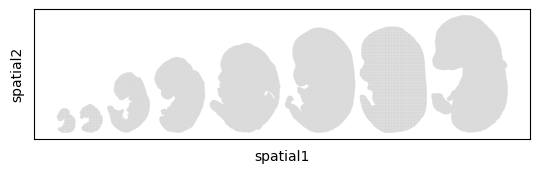

In [9]:
res_path = "Results/INSPIRE_developmental_stages"
adata = sc.read_h5ad(res_path + "/adata_inspire.h5ad")
adata.obsm["spatial"] = loc_full
sc.pl.spatial(adata, spot_size=1)

In [10]:
annotations = ["Cartilage and connective tissue", "Brain region I", "Cavisity",
               "Other", "Meninges", "Jaw and tooth", "Liver", "Epidermis",
               "Muscle", "Brain region II", "Heart", "Lung", "Dorsal root ganglion",
               "Brain region III", "Olfactory epithelium and inner ear", "Sympathetic nerve"]

adata.obs["annotation"] = ""
for i in range(len(annotations)):
    adata.obs["annotation"][adata.obs["louvain"].values.astype(str) == str(i)] = annotations[i]

anno_list = list(sorted(["Cartilage and connective tissue", "Brain region I", "Cavisity",
                         "Meninges", "Jaw and tooth", "Liver", "Epidermis",
                         "Muscle", "Brain region II", "Heart", "Lung", "Dorsal root ganglion",
                         "Brain region III", "Olfactory epithelium and inner ear", "Sympathetic nerve"])) + ["Other"]
adata.obs["anno_num"] = 0
for i, anno in enumerate(anno_list):
    adata.obs["anno_num"][adata.obs["annotation"].values.astype(str) == anno] = i

rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb_dark2 = [i for i in get_cmap('Dark2').colors]
rgb_pst1 = [i for i in get_cmap('Pastel1').colors]
rgb_acc = [i for i in get_cmap('Accent').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex_dark2 = [mpl.colors.rgb2hex(color) for color in rgb_dark2]
rgb2hex_pst1 = [mpl.colors.rgb2hex(color) for color in rgb_pst1]
rgb2hex_acc = [mpl.colors.rgb2hex(color) for color in rgb_acc]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new + rgb2hex_dark2 + rgb2hex_pst1 + rgb2hex_acc

adata.obs["c_hex"] = ""
for i in range(len(annotations)):
    adata.obs["c_hex"][adata.obs["louvain"].values.astype(str) == str(i)] = rgb2hex[i]

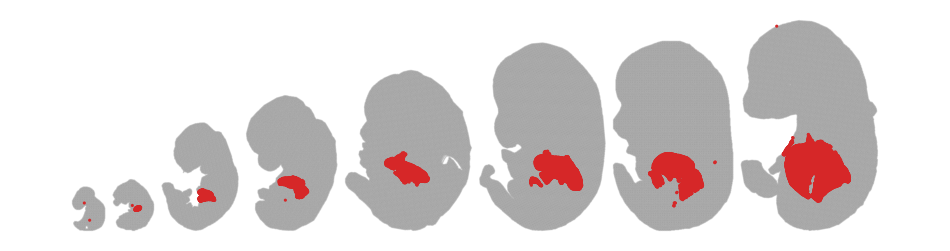

In [11]:
size = 5

# louvain
f = plt.figure(figsize=(12,3))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
colors = rgb2hex
ax.scatter(adata.obsm["spatial"][:, 0], 
          -adata.obsm["spatial"][:, 1], 
          s=1, facecolors="gray", edgecolors='none', alpha=0.1, rasterized=True)
ax.scatter(adata.obsm["spatial"][adata.obs["annotation"].values.astype(str)=="Liver", 0], 
           -adata.obsm["spatial"][adata.obs["annotation"].values.astype(str)=="Liver", 1], 
            s=size, facecolors=adata[adata.obs["annotation"].values.astype(str)=="Liver", :].obs["c_hex"][0], 
           edgecolors='none', rasterized=True)
ax.set_axis_off()
plt.show()

In [12]:
adata.obs["Afp_val"] = 0.
adata.obs["Afp_norm"] = 0.
for i in range(8):
    adata_sub = sc.read_h5ad(os.path.join(preprocessed_data_path, "raw_counts/"+slice_name_list[i]+".h5ad"))
    adata_sub.obs.index = adata_sub.obs.index + "-" + str(i)
    adata.obs["Afp_val"][adata_sub.obs.index] = adata_sub[:, "Afp"].X.toarray().reshape(-1)
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    sc.pp.log1p(adata_sub)
    adata.obs["Afp_norm"][adata_sub.obs.index] = adata_sub[:, "Afp"].X.toarray().reshape(-1)

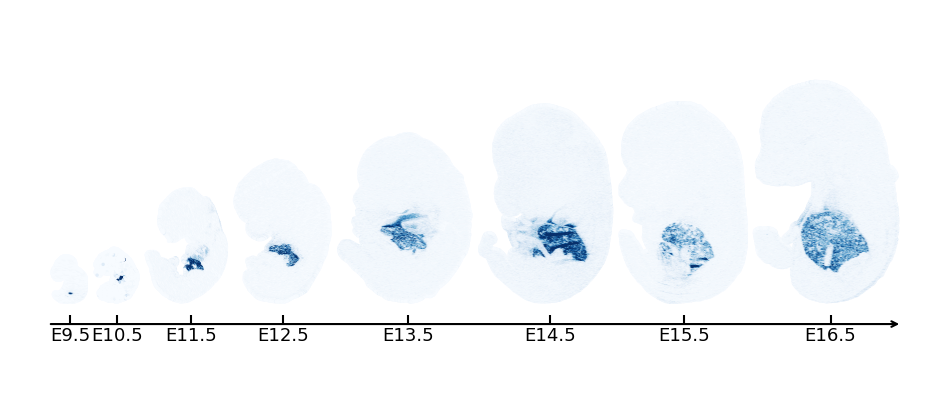

In [14]:
fig = plt.figure(figsize=(12,5))
size = 2.

ax0 = fig.add_subplot(1, 1, 1)
ax0.axis('equal')
x_coor = adata.obsm["spatial"][:, 0] 
y_coor = adata.obsm["spatial"][:, 1]
ax0.scatter(x_coor, -y_coor, s=size, rasterized=True, c=np.array(adata.obs["Afp_val"].values).reshape(-1), cmap="Blues", vmax=40)

y_arrow = 168
ax0.annotate("", xy=(max(loc_list[0][:,0])+10, y_arrow), xytext=(min(loc_list[-1][:,0])-10, y_arrow), arrowprops=dict(arrowstyle="->", lw=1.5))
for i in range(len(loc_list)):
    x_m = np.median(loc_list[i][:, 0])
    plt.vlines(x = x_m, ymin=y_arrow, ymax=y_arrow+20, color = 'k')
    e_val = slice_name_list[i].split("_")[0]
    plt.annotate(e_val, xy=(x_m, y_arrow-40), ha='center', fontsize=13)

ax0.set_axis_off()
plt.ylim(150, 750)
plt.show()

In [15]:
gene = "Afp"
cluster = "Liver"

raw_level = []
norm_level = []

preprocessed_data_path = "examples/mouse_embryo_stereoseq/run_inspire/preprocessed_data"
slice_name_list = ["E16.5_E1S1", "E15.5_E1S2", "E14.5_E1S1", "E13.5_E1S3",
                   "E12.5_E1S1", "E11.5_E1S1", "E10.5_E2S1", "E9.5_E1S1"]

for i in [6,5,4,3,2,1,0]:
    adata = sc.read_h5ad(os.path.join(preprocessed_data_path, "raw_counts/"+slice_name_list[i]+".h5ad"))
    adata.obs.index = adata.obs.index + "-" + str(i)
    meta = meta_full.loc[adata.obs.index]
    adata.obs["annotation"] = meta["annotation"]
    
    adata = adata[adata.obs["annotation"] == cluster, :]
    raw_level.append(adata[:, gene].X.toarray().reshape(-1))
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    norm_level.append(adata[:, gene].X.toarray().reshape(-1))

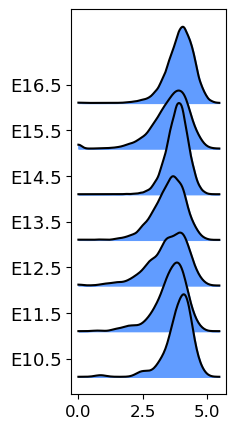

In [16]:
data = norm_level
overlap = 0.5
fill = "#619CFF"
labels = ["E10.5","E11.5","E12.5","E13.5","E14.5","E15.5","E16.5"]
n_points = 150

f = plt.figure(figsize=(2,5))
if overlap > 1 or overlap < 0:
    raise ValueError('overlap must be in [0 1]')
xx = np.linspace(np.min(np.concatenate(data)), np.max(np.concatenate(data)), n_points)
curves = []
ys = []
for i, d in enumerate(data):
    pdf = gaussian_kde(d)
    y = i*(1.0-overlap)
    ys.append(y)
    curve = pdf(xx)
    plt.fill_between(xx, np.ones(n_points)*y, curve+y, zorder=len(data)-i+1, color=fill)
    plt.plot(xx, curve+y, c='k', zorder=len(data)-i+1)
if labels:
    plt.yticks([s+0.2 for s in ys], labels)
plt.yticks(fontsize=13)
plt.xticks(fontsize=12)
plt.show()